In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi


Sat Jul  8 12:12:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.8 MB/s eta 0:00:00


In [ ]:
from transformers import BertModel
from transformers import BertTokenizer
from transformers import get_scheduler

import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

import time
import numpy as np
import os
from tqdm import tqdm

from matplotlib.transforms import Bbox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def tag_to_word(sentence, predictions):
    """
    predictions: list of tags
    sentence: list of words
    """
    terms = []
    for i, word in enumerate(sentence):
        w = None
        if predictions[i] == 1:
            w = word
            for j in range(i+1, len(sentence)):
                if predictions[i] == 2:
                    w += ' ' + sentence[i+1]
                else:
                    terms.append(w)
                    i = j
                    break

    return terms

def tag_to_word_df(df, column_name, tags):
    """
    predictions: list of tags
    sentence: list of words
    """
    terms_list = []
    for i in range(len(df)):
        sentence = df.iloc[i]['Tokens']
        sentence = sentence.replace("'", "").strip("][").split(', ')
        terms = tag_to_word(sentence, tags[i])
        terms_list.append(terms)
    df[column_name] = terms_list
    return df


def word_cloud (data):
    """
    create word cloud from sentence
    """
    from wordcloud import WordCloud
    wordcloud = WordCloud(collocations=False,
                          background_color="cornflowerblue",
                          colormap="tab10",
                          max_words=50).generate(data)

    return wordcloud

def target_predicted_wordcloud(targets, predicted, file_name):
    """
    create word cloud from sentence with target and predicted
    """

    sns.set_theme(style='white', font_scale=1.5)
    fig, ax = plt.subplots(1, 2, figsize=(22, 6))
    ax[0].imshow(word_cloud(targets))
    ax[0].axis("off")
    ax[0].set_title("Target")
    ax[1].imshow(word_cloud(predicted))
    ax[1].axis("off")
    ax[1].set_title("Predicted")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')

def classification_report_read(report_path):
    """
    Read classification report from file
    """

    with open(report_path, 'r') as f:
        report = f.read()
    return report

def print_aligned(report1, report2, title1, title2):
    """
    print two classification report aligned to the columns
    """
    print (1*'\t', title1, 6*'\t', title2)
    report1 = report1.split('\n')
    report2 = report2.split('\n')
    for r1, r2 in zip(report1, report2):
        print(r1, '\t\t', r2)

In [ ]:
class ABTEDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        tokens, tags, pols = self.df.iloc[idx, :3].values

        tokens = tokens.replace("'", "").strip("][").split(', ')
        tags = tags.strip('][').split(', ')
        pols = pols.strip('][').split(', ')

        bert_tokens = []
        bert_tags = []
        bert_pols = []
        for i in range(len(tokens)):
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t
            bert_tags += [int(tags[i])]*len(t)
            bert_pols += [int(pols[i])]*len(t)

        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        ids_tensor = torch.tensor(bert_ids)
        tags_tensor = torch.tensor(bert_tags)
        pols_tensor = torch.tensor(bert_pols)
        return bert_tokens, ids_tensor, tags_tensor, pols_tensor

    def __len__(self):
        return len(self.df)

class ABTEBert(torch.nn.Module):
    def __init__(self, pretrain_model, adapter=True):
        super(ABTEBert, self).__init__()
        self.adapter = adapter
        if adapter:
            from transformers.adapters import BertAdapterModel
            self.bert = BertAdapterModel.from_pretrained(pretrain_model)
        else: self.bert = BertModel.from_pretrained(pretrain_model)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, ids_tensors, tags_tensors, masks_tensors):
        bert_outputs= self.bert(input_ids=ids_tensors, attention_mask=masks_tensors, return_dict=False)
        bert_outputs = bert_outputs[0]

        linear_outputs = self.linear(bert_outputs)
        if tags_tensors is not None:
            tags_tensors = tags_tensors.view(-1)
            linear_outputs = linear_outputs.view(-1,3)
            loss = self.loss_fn(linear_outputs, tags_tensors)
            return loss
        else:
            return linear_outputs

class ABTEModel():
    def __init__(self, tokenizer, adapter=True):
        self.model = ABTEBert('bert-base-uncased', adapter=adapter)
        self.tokenizer = tokenizer
        self.trained = False
        self.adapter = adapter

    def padding(self, samples):
        from torch.nn.utils.rnn import pad_sequence
        ids_tensors = [s[1] for s in samples]
        ids_tensors = pad_sequence(ids_tensors, batch_first=True)

        tags_tensors = [s[2] for s in samples]
        tags_tensors = pad_sequence(tags_tensors, batch_first=True)

        pols_tensors = [s[3] for s in samples]
        pols_tensors = pad_sequence(pols_tensors, batch_first=True)

        masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
        masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

        return ids_tensors, tags_tensors, pols_tensors, masks_tensors

    def load_model(self, model, path):
        model.load_state_dict(torch.load(path), strict=False)

    def save_model(self, model, name):
        torch.save(model.state_dict(), name)

    def train(self, data, epochs, device, batch_size=32, lr=1e-5, load_model=None, lr_schedule=True):

        #load model if lead_model is not None
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
                self.trained = True
            else:
                print("lead_model not found")

        # dataset and loader
        ds = ABTEDataset(data, self.tokenizer)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=self.padding)

        self.model = self.model.to(device)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        num_training_steps = epochs * len(loader)
        if lr_schedule: lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

        self.losses = []

        all_data = len(loader)-1
        for epoch in range(epochs):
            finish_data = 0
            current_times = []
            n_batches = int(len(data)/batch_size)

            if self.adapter:
                if lr_schedule: dir_name  = "model_ABTE_adapter_scheduler"
                else: dir_name = "model_ABTE_adapter"
            else:
                if lr_schedule: dir_name  = "model_ABTE_scheduler"
                else: dir_name = "model_ABTE"

            if not os.path.exists(dir_name):
                os.mkdir(dir_name)

            t0 = time.time()
            for nb in range((n_batches)):

                ids_tensors, tags_tensors, _, masks_tensors = next(iter(loader))
                ids_tensor = ids_tensors.to(device)
                tags_tensor = tags_tensors.to(device)
                masks_tensor = masks_tensors.to(device)
                loss = self.model(ids_tensors=ids_tensor, tags_tensors=tags_tensor, masks_tensors=masks_tensor)
                self.losses.append(loss.item())
                loss.backward()
                optimizer.step()
                if lr_schedule: lr_scheduler.step()
                optimizer.zero_grad()

                finish_data += 1

            current_time = round(time.time() - t0,3)
            current_times.append(current_time)
            print("epoch: {}\tbatch: {}/{}\tloss: {}\tbatch time: {}\ttotal time: {}"\
                .format(epoch, finish_data, all_data, loss.item(), current_time, sum(current_times)))

            np.savetxt('{}/losses_lr{}_epochs{}_batch{}.txt'.format(dir_name, lr, epochs, batch_size), self.losses)

            self.save_model(self.model, 'ABTEmodel_epoch{}.pkl'.format(epoch))
            self.trained = True

    def history (self):
        if self.trained:
            return self.losses
        else:
            raise Exception('Model not trained')

    def predict(self, sentence, load_model=None, device='cpu'):
         # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        word_pieces = list(self.tokenizer.tokenize(sentence))
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        input_tensor = torch.tensor([ids]).to(device)

        #predict
        with torch.no_grad():
            outputs = self.model(input_tensor, None, None)
            _, predictions = torch.max(outputs, dim=2)

        predictions = predictions[0].tolist()
        return word_pieces, predictions, outputs

    def predict_batch(self, data, load_model=None, device='cpu'):

        tags_real = [t.strip('][').split(', ') for t in data['Tags']]
        tags_real = [[int(i) for i in t] for t in tags_real]

        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        predictions = []

        for i in tqdm(range(len(data))):
            sentence = data['Tokens'][i]
            sentence = sentence.replace("'", "").strip("][").split(', ')
            sentence = ' '.join(sentence)
            w, p, _ = self.predict(sentence, load_model=load_model, device=device)
            predictions.append(p)
            tags_real[i] = tags_real[i][:len(p)]

        return predictions, tags_real

    def _accuracy (self, x,y):
        return np.mean(np.array(x) == np.array(y))

    def test(self, dataset, load_model=None, device='cpu'):
        from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

         # dataset and loader
        ds = ABTEDataset(dataset, self.tokenizer)
        loader = DataLoader(ds, batch_size=50, shuffle=True, collate_fn=self.padding)

        pred = []#padded list
        trueth = [] #padded list
        with torch.no_grad():
            for data in tqdm(loader):

                ids_tensors, tags_tensors, _, masks_tensors = data
                ids_tensors = ids_tensors.to(device)
                tags_tensors = tags_tensors.to(device)
                masks_tensors = masks_tensors.to(device)

                outputs = self.model(ids_tensors=ids_tensors, tags_tensors=None, masks_tensors=masks_tensors)

                _, p = torch.max(outputs, dim=2)

                pred += list([int(j) for i in p for j in i ])
                trueth += list([int(j) for i in tags_tensors for j in i ])

        # ROC-Curve
        self.roc_curve(pred, trueth)

        # Confusion Matrix
        cm = confusion_matrix(trueth, pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
        cm_display.plot()
        plt.show()

        acc = self._accuracy(pred, trueth)
        class_report = classification_report(trueth, pred, target_names=['none', 'start of AT', 'mark of AT'])
        return acc, class_report

    def accuracy(self, data, load_model=None, device='cpu'):
        a, p = self.test(data, load_model=load_model, device=device)
        return a

    def roc_curve(self, pred, truth):

        from sklearn.preprocessing import label_binarize
        from sklearn.metrics import roc_curve, auc
        from itertools import cycle

        y_pred = label_binarize(pred, classes=[0,1,2])
        y_truth = label_binarize(truth, classes=[0,1,2])

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        lw=2
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_pred[:, i], y_truth[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        colors = cycle(['blue', 'red', 'green'])
        for i, color in zip(range(3), colors):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i])
            )

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for multi-class data')
        plt.legend(loc="lower right")
        plt.show()

In [ ]:
class ABSADataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        tokens, tags, pols = self.df.iloc[idx, :3].values

        tokens = tokens.replace("'", "").strip("][").split(', ')
        tags = tags.strip('][').split(', ')
        pols = pols.strip('][').split(', ')

        bert_tokens = []
        bert_att = []
        pols_label = 0
        for i in range(len(tokens)):
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t
            if int(pols[i]) != -1:
                bert_att += t
                pols_label = int(pols[i])

        segment_tensor = [0] + [0]*len(bert_tokens) + [0] + [1]*len(bert_att)
        bert_tokens = ['[cls]'] + bert_tokens + ['[sep]'] + bert_att


        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        ids_tensor = torch.tensor(bert_ids)
        pols_tensor = torch.tensor(pols_label)
        segment_tensor = torch.tensor(segment_tensor)

        return bert_tokens, ids_tensor, segment_tensor, pols_tensor

    def __len__(self):
        return len(self.df)

class ABSABert(torch.nn.Module):
    def __init__(self, pretrain_model, adapter=False):
        super(ABSABert, self).__init__()
        self.adapter = adapter
        if adapter:
            from transformers.adapters import BertAdapterModel
            self.bert = BertAdapterModel.from_pretrained(pretrain_model)
        else: self.bert = BertModel.from_pretrained(pretrain_model)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, ids_tensors, lable_tensors, masks_tensors, segments_tensors):
        out_dict = self.bert(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors)
        linear_outputs = self.linear(out_dict['pooler_output'])

        if lable_tensors is not None:
            loss = self.loss_fn(linear_outputs, lable_tensors)
            return loss
        else:
            return linear_outputs

class ABSAModel():
    def __init__(self, tokenizer, adapter=False):
        self.model = ABSABert('bert-base-uncased')
        self.tokenizer = tokenizer
        self.trained = False
        self.adapter = adapter

    def padding(self, samples):
        from torch.nn.utils.rnn import pad_sequence
        ids_tensors = [s[1] for s in samples]
        ids_tensors = pad_sequence(ids_tensors, batch_first=True)

        segments_tensors = [s[2] for s in samples]
        segments_tensors = pad_sequence(segments_tensors, batch_first=True)

        label_ids = torch.stack([s[3] for s in samples])

        masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
        masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

        return ids_tensors, segments_tensors, masks_tensors, label_ids

    def load_model(self, model, path):
        model.load_state_dict(torch.load(path), strict=False)

    def save_model(self, model, name):
        torch.save(model.state_dict(), name)

    def train(self, data, epochs, device, batch_size=32, lr=1e-5, load_model=None, lr_schedule=True):

        #load model if lead_model is not None
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
                self.trained = True
            else:
                print("lead_model not found")

        print ("Training model...")
        print ("Learning rate scheduler: ", lr_schedule)
        print ("Adapter: ", self.adapter)

        ds = ABSADataset(data, self.tokenizer)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=self.padding)

        self.model = self.model.to(device)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)

        num_training_steps = epochs * len(loader)

        # possible choices for scheduler are: "constant", "constant_with_warmup",
        # "polynomial", "cosine_with_restarts", "linear", 'cosine'

        if lr_schedule: lr_scheduler = get_scheduler(name="constant_with_warmup", optimizer=optimizer,
                                    num_warmup_steps=200, num_training_steps=num_training_steps)

        self.losses = []

        all_data = len(loader)-1

        for epoch in range(epochs):
            finish_data = 0
            current_times = []
            n_batches = int(len(data)/batch_size)

            if self.adapter:
                if lr_schedule: dir_name  = "model_ABSA_adapter_scheduler"
                else: dir_name = "model_ABSA_adapter"
            else:
                if lr_schedule: dir_name  = "model_ABSA_scheduler"
                else: dir_name = "model_ABSA"

            if not os.path.exists(dir_name):
                os.mkdir(dir_name)

            t0 = time.time()
            for nb in range((n_batches)):


                ids_tensors, segments_tensors, masks_tensors, label_ids = next(iter(loader))
                ids_tensors = ids_tensors.to(device)
                segments_tensors = segments_tensors.to(device)
                label_ids = label_ids.to(device)
                masks_tensors = masks_tensors.to(device)

                loss = self.model(ids_tensors=ids_tensors, lable_tensors=label_ids,
                                    masks_tensors=masks_tensors, segments_tensors=segments_tensors)
                self.losses.append(loss.item())
                loss.backward()
                optimizer.step()
                if lr_schedule: lr_scheduler.step()
                optimizer.zero_grad()

                finish_data += 1

            current_time = round(time.time() - t0,3)
            current_times.append(current_time)

            print("epoch: {}\tbatch: {}/{}\tloss: {}\tbatch time: {}\ttotal time: {}"\
                .format(epoch, finish_data, all_data, loss.item(), current_time, sum(current_times)))

            np.savetxt('{}/losses_lr{}_epochs{}_batch{}.txt'.format(dir_name, lr, epochs, batch_size), self.losses)

            self.save_model(self.model, 'ABSAmodel_epoch{}.pkl'.format(epoch))
            self.trained = True

    def history (self):
        if self.trained:
            return self.losses
        else:
            raise Exception('Model not trained')

    def predict(self, sentence, aspect, load_model=None, device='cpu'):

        #check that the aspect is in the sentence
        if aspect not in sentence:
            raise Exception('Aspect {} not in sentence \n{}'.format(aspect, sentence))

         # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        t1 = self.tokenizer.tokenize(sentence)
        t2 = self.tokenizer.tokenize(aspect)

        word_pieces = ['[cls]']
        word_pieces += t1
        word_pieces += ['[sep]']
        word_pieces += t2

        segment_tensor = [0] + [0]*len(t1) + [0] + [1]*len(t2)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        input_tensor = torch.tensor([ids]).to(device)
        segment_tensor = torch.tensor(segment_tensor).to(device)

        with torch.no_grad():
            outputs = self.model(input_tensor, None, None, segments_tensors=segment_tensor)
            _, predictions = torch.max(outputs, dim=1)

        return word_pieces, int(predictions)-1, outputs

    def _accuracy (self, x,y):
        acc = 0
        for i in range(len(x)):
            if x[i] == y[i]:
                acc += 1
        return acc/len(x)

    def predict_batch(self, data, load_model=None, device='cpu'):

        tags_real = [t.strip('][').split(', ') for t in data['Tags']]
        tags_real = [[int(i) for i in t ] for t in tags_real]

        polarity_real = [t.strip('][').split(', ') for t in data['Polarities']]
        # if -1 is not an aspect term, if 0 negative, if 2 positive, if 1 neutral, shift of 1
        polarity_real = [[int(i)-1 if int(i)>-1 else None for i in t ] for t in polarity_real]

        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        predictions = []

        for i in tqdm(range(len(data))):
            sentence = data['Tokens'][i]
            sentenceList = sentence.replace("'", "").strip("][").split(', ')
            sentence = ' '.join(sentenceList)
            prediction = []
            for j in range(len(sentenceList)):
                if tags_real[i][j] != 0:
                    aspect = sentenceList[j]

                    w, p, _ = self.predict(sentence, aspect, load_model=load_model, device=device)
                    prediction.append(p)
                else:
                    prediction.append(None)
            predictions.append(prediction)
            polarity_real[i] = polarity_real[i][:len(prediction)]
        return predictions, polarity_real

    def _accuracy (self, x,y):
        return np.mean(np.array(x) == np.array(y))

    def test(self, dataset, load_model=None, device='cpu'):
        from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        # dataset and loader
        ds = ABSADataset(dataset, self.tokenizer)
        loader = DataLoader(ds, batch_size=50, shuffle=True, collate_fn=self.padding)

        pred = []#padded list
        trueth = [] #padded list

        with torch.no_grad():
            for data in tqdm(loader):

                ids_tensors, segments_tensors, masks_tensors, label_ids = data
                ids_tensors = ids_tensors.to(device)
                segments_tensors = segments_tensors.to(device)
                masks_tensors = masks_tensors.to(device)

                outputs = self.model(ids_tensors, None, masks_tensors=masks_tensors,
                                    segments_tensors=segments_tensors)

                _, p = torch.max(outputs, dim=1)
                pred += list([int(i) for i in p])
                trueth += list([int(i) for i in label_ids])

        # ROC-Curve
        self.roc_curve(pred, trueth)

        # Confusion Matrix
        cm = confusion_matrix(trueth, pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
        cm_display.plot()
        plt.show()

        acc = self._accuracy(pred, trueth)
        class_report = classification_report(trueth, pred, target_names=['negative', 'neutral', 'positive'])
        return acc, class_report

    def accuracy(self, data, load_model=None, device='cpu'):
        a, p = self.test(data, load_model=load_model, device=device)
        return a

    def roc_curve(self, pred, truth):

        from sklearn.preprocessing import label_binarize
        from sklearn.metrics import roc_curve, auc
        from itertools import cycle

        y_pred = label_binarize(pred, classes=[-1,0,1,2])
        y_truth = label_binarize(truth, classes=[-1,0,1,2])

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        lw=2
        for i in range(4):
            fpr[i], tpr[i], _ = roc_curve(y_pred[:, i], y_truth[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        colors = cycle(['blue', 'red', 'green', 'orange'])
        for i, color in zip(range(4), colors):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i])
            )

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for multi-class data')
        plt.legend(loc="lower right")
        plt.show()

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import torch

In [ ]:
batch = 10
epochs = 1
lr = 3*1e-5
lr_schedule = True
adapter = False

def mainABTE(batch, epochs, lr, lr_schedule, adapter):

    #load
    data = pd.read_csv('/content/drive/MyDrive/FINAL YEAR PROJECT/dataset/normalized/restaurants_train.csv')
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    modelABTE = ABTEModel(tokenizer, adapter)
    modelABTE.train(data, batch_size=batch, lr=lr, epochs=epochs, device=DEVICE, lr_schedule=lr_schedule)

mainABTE(
    batch,
    epochs,
    lr,
    lr_schedule,
    adapter
)
print('Done')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 0	batch: 360/360	loss: 0.1245795413851738	batch time: 39.809	total time: 39.809
Done


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 23/23 [02:30<00:00,  6.54s/it]


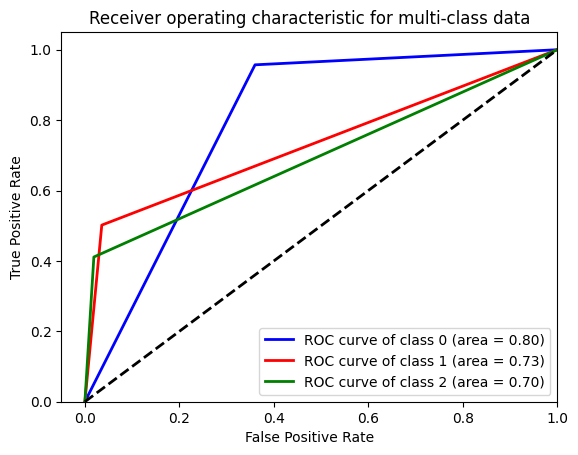

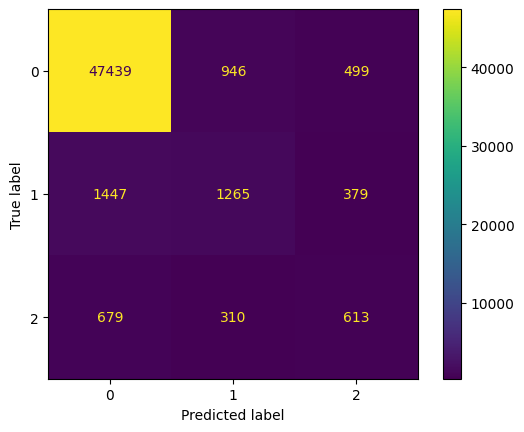

Test Accuracy is: 0.9204882692200012
              precision    recall  f1-score   support

        none       0.96      0.97      0.96     48884
 start of AT       0.50      0.41      0.45      3091
  mark of AT       0.41      0.38      0.40      1602

    accuracy                           0.92     53577
   macro avg       0.62      0.59      0.60     53577
weighted avg       0.91      0.92      0.92     53577



In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/FINAL YEAR PROJECT/dataset/normalized/restaurants_test.csv')
model_path = '/content/drive/MyDrive/FINAL YEAR PROJECT/FinetunedModel/ABTEmodel_epoch0.pkl'
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modelABTE = ABTEModel(tokenizer, adapter)

acc, class_report = modelABTE.test(test_data, load_model=model_path)

print("Test Accuracy is:", acc)
print(class_report)

In [ ]:
batch = 8
epochs = 5
lr = 1e-5
lr_schedule = True
adapter = False

def mainABSA(batch, epochs, lr, lr_schedule, adapter):

    #load
    data = pd.read_csv('/content/drive/MyDrive/FINAL YEAR PROJECT/dataset/normalized/restaurants_train.csv')

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    modelABSA = ABSAModel(tokenizer, adapter=adapter)
    modelABSA.train(data, batch_size=batch, lr=lr, epochs=epochs, device=DEVICE, lr_schedule=True)

mainABSA(
    batch,
    epochs,
    lr,
    lr_schedule,
    adapter
)
print('Done')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training model...
Learning rate scheduler:  True
Adapter:  False
epoch: 0	batch: 450/450	loss: 0.42500635981559753	batch time: 42.409	total time: 42.409
epoch: 1	batch: 450/450	loss: 0.6224507093429565	batch time: 49.829	total time: 49.829
epoch: 2	batch: 450/450	loss: 0.016501905396580696	batch time: 44.885	total time: 44.885
epoch: 3	batch: 450/450	loss: 0.007854068651795387	batch time: 42.436	total time: 42.436
epoch: 4	batch: 450/450	loss: 0.03898361325263977	batch time: 42.517	total time: 42.517
Done


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 23/23 [02:51<00:00,  7.48s/it]


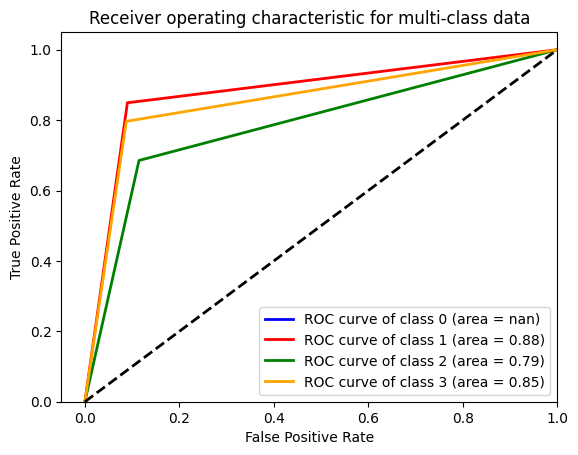

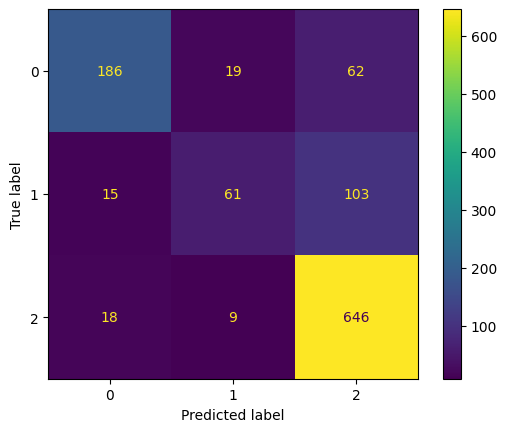

Test Accuracy is: 0.7980339588918678
              precision    recall  f1-score   support

    negative       0.85      0.70      0.77       267
     neutral       0.69      0.34      0.46       179
    positive       0.80      0.96      0.87       673

    accuracy                           0.80      1119
   macro avg       0.78      0.67      0.70      1119
weighted avg       0.79      0.80      0.78      1119



In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/FINAL YEAR PROJECT/dataset/normalized/restaurants_test.csv')
model_path = '/content/drive/MyDrive/FINAL YEAR PROJECT/FinetunedModel/ABSAmodel_epoch4.pkl'
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modelABSA = ABSAModel(tokenizer, adapter)

acc, class_report = modelABSA.test(test_data, load_model=model_path)

print("Test Accuracy is:", acc)
print(class_report)

In [ ]:
def predict_sentiment_ABSA(review, aspect, model, model_path):
    x, y, z = model.predict(review, aspect, load_model=model_path)

    print(y)

    if y == 1:
        return 'The review "{}" \nw.r.t. the aspect "{}" is positive\n'.format(review, aspect)
    elif y == 0:
        return 'The review "{}" \nw.r.t. the aspect "{}" is neutral\n'.format(review, aspect)
    else:
        return 'The review "{}" \nw.r.t. the aspect "{}" is negative\n'.format(review, aspect)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cpu")
model_path = '/content/drive/MyDrive/FINAL YEAR PROJECT/FinetunedModel/ABSAmodel_epoch4.pkl'
modelABSA = ABSAModel(tokenizer, adapter=False)

print (predict_sentiment_ABSA("they make the BEST spice tuna roll in town, and the asian salad is fine", "asian", modelABSA, model_path)+"\n")
print (predict_sentiment_ABSA("the food is fantastic, but the prices were too high", "prices", modelABSA, model_path)+"\n")
print (predict_sentiment_ABSA("the food is fantastic, but the prices were too high", "food", modelABSA, model_path)+"\n")
print (predict_sentiment_ABSA("the chicken tastes like plastic, even tough they make the best ", "chicken", modelABSA, model_path)+"\n")
print (predict_sentiment_ABSA("the food doesn't taste good", "food", modelABSA, model_path)+"\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1
The review "they make the BEST spice tuna roll in town, and the asian salad is fine" 
w.r.t. the aspect "asian" is positive


-1
The review "the food is fantastic, but the prices were too high" 
w.r.t. the aspect "prices" is negative


1
The review "the food is fantastic, but the prices were too high" 
w.r.t. the aspect "food" is positive


1
The review "the chicken tastes like plastic, even tough they make the best " 
w.r.t. the aspect "chicken" is positive


-1
The review "the food doesn't taste good" 
w.r.t. the aspect "food" is negative




In [ ]:
def predict_sentiment_ABTE(review, model, model_path):
    x, y, z = model.predict(review, load_model=model_path)
    terms = tag_to_word(x, y)
    print(terms)


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/FINAL YEAR PROJECT/FinetunedModel/ABTEmodel_epoch4.pkl'
modelABTE = ABTEModel(tokenizer, adapter=False)

print (predict_sentiment_ABTE("they make the BEST spice tuna roll in town, and the asian salad is ok", modelABTE, model_path))
print (predict_sentiment_ABTE("the food is fantastic, but the prices were too high", modelABTE, model_path))
print (predict_sentiment_ABTE("the food is fantastic, but the prices were too high", modelABTE, model_path))
print (predict_sentiment_ABTE("the chicken tastes like plastic, even tough they make the best ", modelABTE, model_path))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['spice', 'asian', 'salad']
None
['food', 'were']
None
['food', 'were']
None
['chicken']
None
